In [1]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [3]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
Installing dependencies from lock file

Package operations: 0 installs, 3 updates, 0 removals

  • Updating importlib-metadata (6.7.0 -> 5.2.0)
  • Updating urllib3 (1.26.16 -> 2.0.3)
  • Updating p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
circuitsvis 1.40.0 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.


In [4]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer

In [5]:
# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
torch.cuda.is_available()

True

In [8]:
# import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [9]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [10]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

In [11]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [12]:
fact_prompts = [
    {
        "format" : "{} is made of{}",
        "subject": "Wine",
        "object": " grapes",
        "correction" : " bananas",
    },
    {
        "format": "{} is the capital of{}",
        "subject": "Paris",
        "object":" France",
        "correction":" England"
    },
    {
        "format" : "{} is located in{}",
        "subject" : "The Eiffel Tower",
        "object" : " Paris",
        "correction":" Rome"
    },
    {
        "format" : "{} is located in{}",
        "subject" : "The Space Needle",
        "object" : " Seattle",
        "correction":" Paris"
    },
]
for prompt in fact_prompts:
    prompt["subject_sentence"] = prompt["format"].format(
        prompt["subject"], ""
    )
    prompt["correct_sentence"] = prompt["format"].format(
        prompt["subject"], prompt["object"]
    )
    prompt["counterfactual_sentence"] = prompt['format'].format(
        prompt["subject"], prompt["correction"]
    )
fact_prompts


[{'format': '{} is made of{}',
  'subject': 'Wine',
  'object': ' grapes',
  'correction': ' bananas',
  'subject_sentence': 'Wine is made of',
  'correct_sentence': 'Wine is made of grapes',
  'counterfactual_sentence': 'Wine is made of bananas'},
 {'format': '{} is the capital of{}',
  'subject': 'Paris',
  'object': ' France',
  'correction': ' England',
  'subject_sentence': 'Paris is the capital of',
  'correct_sentence': 'Paris is the capital of France',
  'counterfactual_sentence': 'Paris is the capital of England'},
 {'format': '{} is located in{}',
  'subject': 'The Eiffel Tower',
  'object': ' Paris',
  'correction': ' Rome',
  'subject_sentence': 'The Eiffel Tower is located in',
  'correct_sentence': 'The Eiffel Tower is located in Paris',
  'counterfactual_sentence': 'The Eiffel Tower is located in Rome'},
 {'format': '{} is located in{}',
  'subject': 'The Space Needle',
  'object': ' Seattle',
  'correction': ' Paris',
  'subject_sentence': 'The Space Needle is located i

## Checking Logits

In [13]:
#logits for correct answer
for prompt in fact_prompts:
    subject_prompt = prompt["format"].format(
        prompt["subject"], ""
    )
    test_answer = prompt["object"]
    utils.test_prompt(subject_prompt, test_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'W', 'ine', ' is', ' made', ' of']
Tokenized answer: [' grapes']


Performance on answer token:
Rank: 3        Logit: 12.52 Prob:  3.24% Token: | grapes|

Top 0th token. Logit: 13.00 Prob:  5.25% Token: | a|
Top 1th token. Logit: 12.96 Prob:  5.08% Token: | wine|
Top 2th token. Logit: 12.87 Prob:  4.61% Token: | the|
Top 3th token. Logit: 12.52 Prob:  3.24% Token: | grapes|
Top 4th token. Logit: 11.81 Prob:  1.61% Token: | two|
Top 5th token. Logit: 11.68 Prob:  1.40% Token: | pure|
Top 6th token. Logit: 11.51 Prob:  1.19% Token: | grape|
Top 7th token. Logit: 11.50 Prob:  1.17% Token: | fine|
Top 8th token. Logit: 11.34 Prob:  1.00% Token: | three|
Top 9th token. Logit: 11.30 Prob:  0.96% Token: | wines|


Ranks of the answer tokens: [(' grapes', 3)]

Tokenized prompt: ['<|endoftext|>', 'Paris', ' is', ' the', ' capital', ' of']
Tokenized answer: [' France']


Performance on answer token:
Rank: 0        Logit: 16.93 Prob: 33.42% Token: | France|

Top 0th token. Logit: 16.93 Prob: 33.42% Token: | France|
Top 1th token. Logit: 16.61 Prob: 24.46% Token: | the|
Top 2th token. Logit: 15.30 Prob:  6.59% Token: | a|
Top 3th token. Logit: 14.68 Prob:  3.52% Token: | Europe|
Top 4th token. Logit: 13.98 Prob:  1.75% Token: | French|
Top 5th token. Logit: 13.93 Prob:  1.67% Token: | Paris|
Top 6th token. Logit: 13.78 Prob:  1.43% Token: | Belgium|
Top 7th token. Logit: 13.75 Prob:  1.39% Token: | one|
Top 8th token. Logit: 13.22 Prob:  0.82% Token: | an|
Top 9th token. Logit: 12.86 Prob:  0.57% Token: | Germany|


Ranks of the answer tokens: [(' France', 0)]

Tokenized prompt: ['<|endoftext|>', 'The', ' E', 'iff', 'el', ' Tower', ' is', ' located', ' in']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 5        Logit: 12.79 Prob:  1.89% Token: | Paris|

Top 0th token. Logit: 15.49 Prob: 28.07% Token: | the|
Top 1th token. Logit: 13.75 Prob:  4.91% Token: | a|
Top 2th token. Logit: 13.63 Prob:  4.37% Token: | central|
Top 3th token. Logit: 13.56 Prob:  4.08% Token: | London|
Top 4th token. Logit: 13.20 Prob:  2.86% Token: | downtown|
Top 5th token. Logit: 12.79 Prob:  1.89% Token: | Paris|
Top 6th token. Logit: 12.61 Prob:  1.57% Token: | New|
Top 7th token. Logit: 12.55 Prob:  1.48% Token: | Berlin|
Top 8th token. Logit: 12.53 Prob:  1.46% Token: | an|
Top 9th token. Logit: 12.25 Prob:  1.10% Token: | Manhattan|


Ranks of the answer tokens: [(' Paris', 5)]

Tokenized prompt: ['<|endoftext|>', 'The', ' Space', ' Need', 'le', ' is', ' located', ' in']
Tokenized answer: [' Seattle']


Performance on answer token:
Rank: 19       Logit:  9.55 Prob:  0.20% Token: | Seattle|

Top 0th token. Logit: 14.90 Prob: 42.07% Token: | the|
Top 1th token. Logit: 13.47 Prob: 10.05% Token: | a|
Top 2th token. Logit: 12.25 Prob:  2.95% Token: | an|
Top 3th token. Logit: 11.44 Prob:  1.32% Token: | downtown|
Top 4th token. Logit: 11.11 Prob:  0.95% Token: | your|
Top 5th token. Logit: 11.05 Prob:  0.90% Token: | our|
Top 6th token. Logit: 10.95 Prob:  0.81% Token: | one|
Top 7th token. Logit: 10.92 Prob:  0.78% Token: | front|
Top 8th token. Logit: 10.21 Prob:  0.39% Token: | San|
Top 9th token. Logit: 10.18 Prob:  0.38% Token: | central|


Ranks of the answer tokens: [(' Seattle', 19)]

In [14]:
#logits for correct answer

for prompt in fact_prompts:
    subject_prompt = prompt["format"].format(
        prompt["subject"], ""
    )
    test_answer = prompt["correction"]
    utils.test_prompt(subject_prompt, test_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'W', 'ine', ' is', ' made', ' of']
Tokenized answer: [' bananas']


Performance on answer token:
Rank: 1088     Logit:  6.70 Prob:  0.01% Token: | bananas|

Top 0th token. Logit: 13.00 Prob:  5.25% Token: | a|
Top 1th token. Logit: 12.96 Prob:  5.08% Token: | wine|
Top 2th token. Logit: 12.87 Prob:  4.61% Token: | the|
Top 3th token. Logit: 12.52 Prob:  3.24% Token: | grapes|
Top 4th token. Logit: 11.81 Prob:  1.61% Token: | two|
Top 5th token. Logit: 11.68 Prob:  1.40% Token: | pure|
Top 6th token. Logit: 11.51 Prob:  1.19% Token: | grape|
Top 7th token. Logit: 11.50 Prob:  1.17% Token: | fine|
Top 8th token. Logit: 11.34 Prob:  1.00% Token: | three|
Top 9th token. Logit: 11.30 Prob:  0.96% Token: | wines|


Ranks of the answer tokens: [(' bananas', 1088)]

Tokenized prompt: ['<|endoftext|>', 'Paris', ' is', ' the', ' capital', ' of']
Tokenized answer: [' England']


Performance on answer token:
Rank: 95       Logit: 10.47 Prob:  0.05% Token: | England|

Top 0th token. Logit: 16.93 Prob: 33.42% Token: | France|
Top 1th token. Logit: 16.61 Prob: 24.46% Token: | the|
Top 2th token. Logit: 15.30 Prob:  6.59% Token: | a|
Top 3th token. Logit: 14.68 Prob:  3.52% Token: | Europe|
Top 4th token. Logit: 13.98 Prob:  1.75% Token: | French|
Top 5th token. Logit: 13.93 Prob:  1.67% Token: | Paris|
Top 6th token. Logit: 13.78 Prob:  1.43% Token: | Belgium|
Top 7th token. Logit: 13.75 Prob:  1.39% Token: | one|
Top 8th token. Logit: 13.22 Prob:  0.82% Token: | an|
Top 9th token. Logit: 12.86 Prob:  0.57% Token: | Germany|


Ranks of the answer tokens: [(' England', 95)]

Tokenized prompt: ['<|endoftext|>', 'The', ' E', 'iff', 'el', ' Tower', ' is', ' located', ' in']
Tokenized answer: [' Rome']


Performance on answer token:
Rank: 87       Logit: 10.00 Prob:  0.12% Token: | Rome|

Top 0th token. Logit: 15.49 Prob: 28.07% Token: | the|
Top 1th token. Logit: 13.75 Prob:  4.91% Token: | a|
Top 2th token. Logit: 13.63 Prob:  4.37% Token: | central|
Top 3th token. Logit: 13.56 Prob:  4.08% Token: | London|
Top 4th token. Logit: 13.20 Prob:  2.86% Token: | downtown|
Top 5th token. Logit: 12.79 Prob:  1.89% Token: | Paris|
Top 6th token. Logit: 12.61 Prob:  1.57% Token: | New|
Top 7th token. Logit: 12.55 Prob:  1.48% Token: | Berlin|
Top 8th token. Logit: 12.53 Prob:  1.46% Token: | an|
Top 9th token. Logit: 12.25 Prob:  1.10% Token: | Manhattan|


Ranks of the answer tokens: [(' Rome', 87)]

Tokenized prompt: ['<|endoftext|>', 'The', ' Space', ' Need', 'le', ' is', ' located', ' in']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 236      Logit:  7.57 Prob:  0.03% Token: | Paris|

Top 0th token. Logit: 14.90 Prob: 42.07% Token: | the|
Top 1th token. Logit: 13.47 Prob: 10.05% Token: | a|
Top 2th token. Logit: 12.25 Prob:  2.95% Token: | an|
Top 3th token. Logit: 11.44 Prob:  1.32% Token: | downtown|
Top 4th token. Logit: 11.11 Prob:  0.95% Token: | your|
Top 5th token. Logit: 11.05 Prob:  0.90% Token: | our|
Top 6th token. Logit: 10.95 Prob:  0.81% Token: | one|
Top 7th token. Logit: 10.92 Prob:  0.78% Token: | front|
Top 8th token. Logit: 10.21 Prob:  0.39% Token: | San|
Top 9th token. Logit: 10.18 Prob:  0.38% Token: | central|


Ranks of the answer tokens: [(' Paris', 236)]

## Logit Difference

In [46]:
def get_logit_difference(prompts,
                         correct_answer,
                         counterfactual_answer,
                         per_prompt=False):
    differences = []
    for prompt, correct, counter in zip(prompts, correct_answer, counterfactual_answer):
        prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
        logits, _ = model.run_with_cache(prompt_tokens)
        #logits shape : prompts x tokens x vocab_size
        final_logits = logits[:,-1,:]
        correct_answer_token = model.to_tokens(correct)[:,-1].unsqueeze(-1)
        counter_answer_token = model.to_tokens(counter)[:,-1].unsqueeze(-1)
        correct_answer_logits = final_logits.gather(dim=-1, index=correct_answer_token)
        counter_factual_logits = final_logits.gather(dim=-1, index=counter_answer_token)
        diffs = correct_answer_logits.item() - counter_factual_logits.item()
        differences.append(diffs)
    differences = torch.tensor(differences)
    avg = torch.mean(differences)
    print("Prompt logit differences", differences)
    print(f"Average logit difference (probability {torch.exp(avg):.2f}x of correct over counter): {avg.item():.2f}")
    if per_prompt:
        return differences
    else:
        return avg


prompts = [p["subject_sentence"] for p in fact_prompts]
correct_answers = [p["object"] for p in fact_prompts]
counterfactual_answers = [p["correction"] for p in fact_prompts]

_ = get_logit_difference(prompts, correct_answers, counterfactual_answers)

Prompt logit differences tensor([5.8121, 6.4513, 2.7905, 1.9786])
Average logit difference (probability 70.68x of correct over counter): 4.26


In [47]:
prompts

['Wine is made of',
 'Paris is the capital of',
 'The Eiffel Tower is located in',
 'The Space Needle is located in']

In [48]:
correct_answers

[' grapes', ' France', ' Paris', ' Seattle']

In [49]:
counterfactual_answers

[' bananas', ' England', ' Rome', ' Paris']

We want to identify where exactly these facts are located in the model. To do so, we will try direct logit attribution and causal tracing.

Note that we cannot take the average over our three prompts as theyre different facts. We'll focus on the facts seperately. For more statistical robustness, we will need to have multiple prompt indicating the same thing. this is likely easiest done by introducing small noise on the token channels of the relation between subject and object.

## Direct Logit Attribution

Some useful things to remember:
- The central object in the transformer is the residual stream. It is a per token stream of subspaces in which each subspace is a representation of the token.
- The residual stream is the sum of the outputs for each layer and of the original token and position embedding.
- Each attention head 'reads' from the stream using linear transformations and 'writes' to the stream using concatenation of heads and then linear transformation. Concatenation is seen as mathematically equivalent to summing and then linear transformation. Therefore the residual stream can be decomposed as a contribution of each attention head.
- The MLP is composed of W_in, non-linear transformation and then W_out, so similarly has linear read and write maps. So, the residual stream can be decomposed in very much the same way.
- Layer Norm is an almost linear map. Layer norm is like batch norm for transformers. Layer Norm normaqlized the vector at each position and then applies a learned vector of weights and biases to scale and translate the normalized vector. The whole operation is linear, except for the division by the vector norm during scaling. We can hard fix the scale factor and therefore make Layer Norm fully linear.

Lets start by padding the prompts such that every prompt has the same number of tokens

In [50]:
sentence_idx = 1

In [51]:
def get_residual_directions(tokens):
    """Maps tokens to a tensor with the unembedding vector for those tokens, ie the vector in the residual stream
        that we dot with to the get the logit for that token.
    residual_direction = self.W_U[:, token]
    W_U.shape = [768, 50257] = [residual_dim, vocab_size]
    We index the residual direction for a given token
    """
    return model.tokens_to_residual_directions(tokens)


In [52]:
correct_tokens = model.to_tokens(correct_answers[sentence_idx])[:,-1]
counter_tokens = model.to_tokens(counterfactual_answers[sentence_idx])[:,-1]

#we get the directions for the directions of both answers
correct_answer_residual_directions = get_residual_directions(correct_tokens)
counter_factual_residual_directions = get_residual_directions(counter_tokens)

logit_diff_directions = correct_answer_residual_directions - \
                            counter_factual_residual_directions
#add batch_dim
logit_diff_directions = logit_diff_directions.unsqueeze(0)



In [53]:
logit_diff_directions.shape

torch.Size([1, 768])

In [54]:
prompt = fact_prompts[sentence_idx]["subject_sentence"]
prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
logits, cache = model.run_with_cache(prompt_tokens)

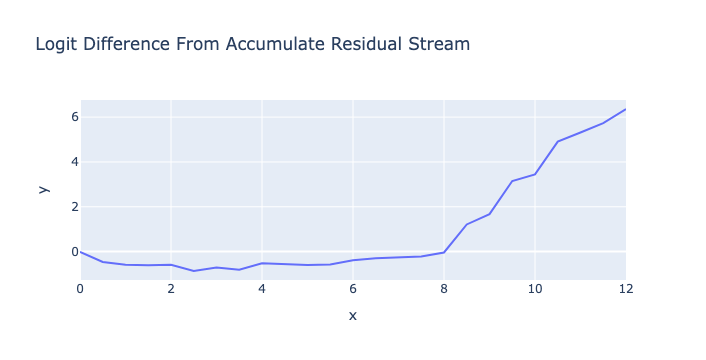

In [55]:
def residual_stack_to_logit_diff(residual_stack, cache, logit_diff_directions) -> float:
    """
    Takes a stack of components of the residual stream (eg outputs of decompose_resid or accumulated_resid), treats them as the input to a specific layer, and applies the layer norm scaling of that layer to them, using the cached scale factors - simulating what that component of the residual stream contributes to that layer's input.
    The layernorm scale is global across the entire residual stream for each layer, batch element and position, which is why we need to use the cached scale factors rather than just applying a new LayerNorm.
    """
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)

    #here we take our scaled residual_stack and dot product it with the logit difference
    #this gives us the contribution of a channel in the scaled residual stack to the
    #logit difference on that chanel
    channel_logit_contribution = einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/logit_diff_directions.shape[0]
    return channel_logit_contribution


accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
#accumulated residual is the state of the residual stream of the cache on each layer
#a given state is dependent on all previous layers
#labels is for graphing

logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache, logit_diff_directions)


line(logit_lens_logit_diffs, x=np.arange(model.cfg.n_layers*2+1)/2, hover_name=labels, title="Logit Difference From Accumulate Residual Stream")

## Layer Attribution
the logit difference above is cumulative through the model. We can decompose this per layer.

In [56]:
sentence_idx = -1

In [57]:
prompt = fact_prompts[sentence_idx]["subject_sentence"]
prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
logits, cache = model.run_with_cache(prompt_tokens)

In [58]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)

per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache, logit_diff_directions)

# line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

Results of Per Layer Logit Attribution seem pretty volatile. Let's see if:
1. Mean over different prompt with same information improves this.
2. Introducing per channel noise improves this.

In [59]:
multi_prompts_formats = {
        'format': '{subject} {relation}{object_}',
        'subject': 'The Eiffel Tower',
        'object': ' Paris',
        'correction': ' Rome',
        'relations': [
            "is located in",
            "is situated in",
            "is based in",
            "is found in"
        ]
}
multi_prompts = [
    multi_prompts_formats["format"].format(subject=multi_prompts_formats["subject"],
                                           relation=relation,
                                           object_="")
    for relation in multi_prompts_formats["relations"]
]
for m in multi_prompts:
    print(len(model.to_str_tokens(m)))

correct_answer = multi_prompts_formats["object"]
counterfact_answer = multi_prompts_formats["correction"]


9
9
9
9


In [60]:
prompt_tokens = model.to_tokens(multi_prompts, prepend_bos=True)
logits, cache = model.run_with_cache(prompt_tokens)

In [61]:
correct_tokens = model.to_tokens(correct_answer)[:,-1].item()
counter_tokens = model.to_tokens(counterfact_answer)[:,-1].item()
answer_tokens = [[correct_tokens, counter_tokens] for _ in multi_prompts]
answer_tokens = torch.tensor(answer_tokens)

answer_residual_directions = get_residual_directions(answer_tokens)

logit_diff_directions = answer_residual_directions[:,0,:] - \
                            answer_residual_directions[:,-1,:]


In [62]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache, logit_diff_directions)

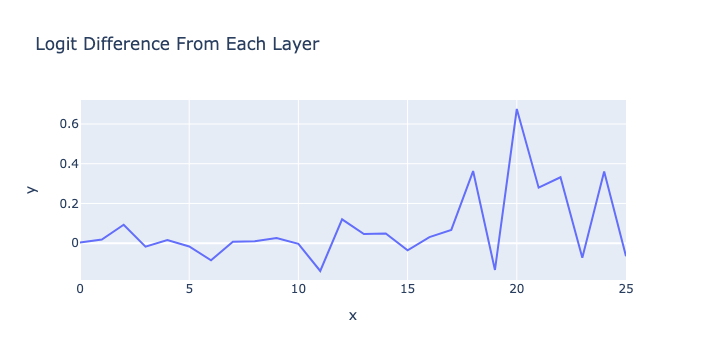

In [63]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache, logit_diff_directions)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

In [64]:
tokens = prompt_tokens
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: Optional[ActivationCache]=None,
    local_tokens: Optional[torch.Tensor]=None,
    title: str=""):
    # Heads are given as a list of integers or a single integer in [0, n_layers * n_heads)
    if isinstance(heads, int):
        heads = [heads]
    elif isinstance(heads, list) or isinstance(heads, torch.Tensor):
        heads = utils.to_numpy(heads)
    # Cache defaults to the original activation cache
    if local_cache is None:
        local_cache = cache
    # Tokens defaults to the tokenization of the first prompt (including the BOS token)
    if local_tokens is None:
        # The tokens of the first prompt
        local_tokens = tokens[0]

    labels = []
    patterns = []
    batch_index = 0
    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])
        labels.append(f"L{layer}H{head_index}")
    str_tokens = model.to_str_tokens(local_tokens)
    patterns = torch.stack(patterns, dim=-1)
    # Plot the attention patterns
    attention_vis = pysvelte.AttentionMulti(attention=patterns, tokens=str_tokens, head_labels=labels)
    display(HTML(f"<h3>{title}</h3>"))
    attention_vis.show()

### Head Attribution

Tried to stack head results when they weren't cached. Computing head results now


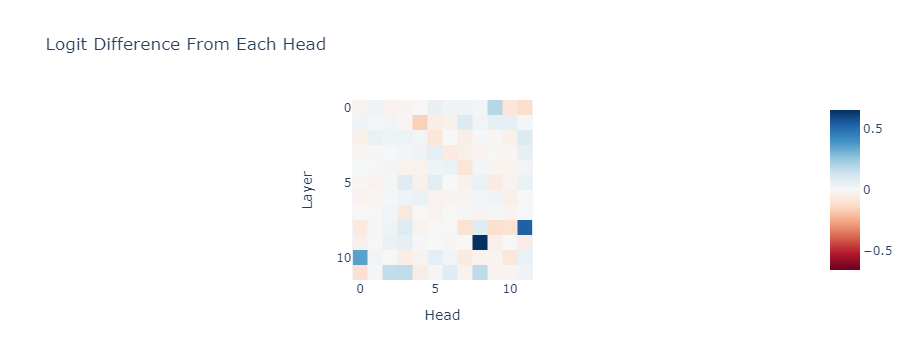

In [65]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache,logit_diff_directions)
per_head_logit_diffs = einops.rearrange(per_head_logit_diffs, "(layer head_index) -> layer head_index", layer=model.cfg.n_layers, head_index=model.cfg.n_heads)
imshow(per_head_logit_diffs, labels={"x":"Head", "y":"Layer"}, title="Logit Difference From Each Head")

In [66]:
top_k = 100
top_positive_logit_attr_heads = torch.topk(per_head_logit_diffs.flatten(), k=top_k).indices
visualize_attention_patterns(top_positive_logit_attr_heads, title=f"Top {top_k} Positive Logit Attribution Heads")
top_negative_logit_attr_heads = torch.topk(-per_head_logit_diffs.flatten(), k=top_k).indices
visualize_attention_patterns(top_negative_logit_attr_heads, title=f"Top {top_k} Negative Logit Attribution Heads")

NameError: name 'pysvelte' is not defined

## Method2: Causal Tracing using Activation Patching


The setup of activation patching is to take two runs of the model on two different inputs, the clean run and the corrupted run. The clean run outputs the correct answer and the corrupted run does not. The key idea is that we give the model the corrupted input, but then **intervene** on a specific activation and **patch** in the corresponding activation from the clean run (ie replace the corrupted activation with the clean activation), and then continue the run. And we then measure how much the output has updated towards the correct answer.

We can then iterate over many possible activations and look at how much they affect the corrupted run. If patching in an activation significantly increases the probability of the correct answer, this allows us to *localise* which activations matter.

In [67]:
sentence_idx = 2

In [68]:
prompt = fact_prompts[sentence_idx]
prompt

{'format': '{} is located in{}',
 'subject': 'The Eiffel Tower',
 'object': ' Paris',
 'correction': ' Rome',
 'subject_sentence': 'The Eiffel Tower is located in',
 'correct_sentence': 'The Eiffel Tower is located in Paris',
 'counterfactual_sentence': 'The Eiffel Tower is located in Rome'}

In [73]:
device = "cuda"

In [74]:
#we want to corrupt the subject tokens
original_prompt = prompt["subject_sentence"]

original_prompts = "The Eiffel street is located in'"



correct_answer = prompt["object"]
incorrect_answer = prompt["correction"]

subject_tokens = model.to_tokens(prompt["subject"])
original_prompt_tokens = model.to_tokens(original_prompt)

In [78]:
#factor by which to multiply std of noise
noise_multiplier = 8
# Create a boolean tensor indicating if elements of 'a' are in 'b'
noise_idx = torch.unsqueeze(subject_tokens, 2) == torch.unsqueeze(original_prompt_tokens, 1)
# Reduce the result tensor to get the final True/False tensor
noise_idx = torch.any(noise_idx, dim=1)
noise_scale = model.W_E.std(dim=-1).mean(dim=-1) * noise_multiplier

d_model = model.W_E.shape[-1]
batch_size = noise_idx.shape[0]
n_tokens = noise_idx.shape[-1]

#random gaussian tensor scaled buy x times W_E std

noisy_facts = []
n_samples = 100

for n in range(n_samples):
    noise = torch.randn(n_tokens, d_model).to(device)*noise_scale.to(device)
    noise = torch.where(noise_idx.unsqueeze(-1), noise, torch.tensor(0.0).cuda())

    embeddings = model.embed(original_prompt_tokens) #[batch] x [n_tokens] x [residual_dim]
    embeddings = embeddings + noise

    logits = model.unembed(embeddings)  #[batch] x [n_tokens] x [vocab_size]
    tokens = torch.argmax(logits, dim=-1) #[batch] x [n_tokens]
    for batch_tokens in tokens:
        noisy_facts.append(model.tokenizer.decode(batch_tokens))


In [79]:
string_lengths = [len(model.to_str_tokens(s)) for s in noisy_facts]
length_counts = {length: string_lengths.count(length) for length in set(string_lengths)}
most_common_length = max(length_counts, key=length_counts.get)
noisy_facts = [s for s in noisy_facts if len(model.to_str_tokens(s)) == most_common_length]
noisy_facts = [n for n in noisy_facts if "<|endoftext|>" not in n]
noisy_facts[:5]


['schildTI Kittphpulously describ is located in',
 'yrinth========anchesterwagenidan flock is located in',
 ' latt Motion Cindatureswaansion is located in',
 'Interstitial░FU Nept░udence is located in',
 'interstitial assumisexual horizontonds carbohyd is located in']

In [80]:
most_common_length

10

We now intervene on the corrupted run and patch in the clean residual stream at a specific layer and position.

We do the intervention using TransformerLens's `HookPoint` feature. We can design a hook function that takes in a specific activation and returns an edited copy, and temporarily add it in with `model.run_with_hooks`.

In [81]:
corrupted_prompts = noisy_facts[:10]

In [82]:
def pad_original_fact(original_fact, n):
    original_fact_tokens = model.to_str_tokens(original_fact)
    while len(original_fact_tokens) < n:
        original_fact = " " + original_fact
        original_fact_tokens = model.to_str_tokens(original_fact)
    return original_fact

padded_original_prompt = pad_original_fact(original_prompt, most_common_length)
padded_original_prompts = [padded_original_prompt for _ in (corrupted_prompts)]
padded_original_prompt_tokens = model.to_tokens(padded_original_prompts, prepend_bos=True)

In [83]:
utils.test_prompt(padded_original_prompt, correct_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', ' ', ' The', ' E', 'iff', 'el', ' Tower', ' is', ' located', ' in']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 6        Logit: 12.21 Prob:  1.55% Token: | Paris|

Top 0th token. Logit: 15.20 Prob: 30.58% Token: | the|
Top 1th token. Logit: 13.20 Prob:  4.14% Token: | a|
Top 2th token. Logit: 12.78 Prob:  2.72% Token: | London|
Top 3th token. Logit: 12.74 Prob:  2.60% Token: | central|
Top 4th token. Logit: 12.49 Prob:  2.04% Token: | downtown|
Top 5th token. Logit: 12.34 Prob:  1.75% Token: | New|
Top 6th token. Logit: 12.21 Prob:  1.55% Token: | Paris|
Top 7th token. Logit: 12.02 Prob:  1.27% Token: | Berlin|
Top 8th token. Logit: 12.00 Prob:  1.25% Token: | an|
Top 9th token. Logit: 11.76 Prob:  0.98% Token: | Amsterdam|


Ranks of the answer tokens: [(' Paris', 6)]

In [84]:
utils.test_prompt(corrupted_prompts[0], correct_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'schild', 'TI', ' Kitt', 'php', 'ulously', ' describ', ' is', ' located', ' in']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 28       Logit:  8.63 Prob:  0.29% Token: | Paris|

Top 0th token. Logit: 12.85 Prob: 19.53% Token: | the|
Top 1th token. Logit: 11.36 Prob:  4.41% Token: | a|
Top 2th token. Logit: 10.26 Prob:  1.46% Token: | New|
Top 3th token. Logit:  9.85 Prob:  0.98% Token: | an|
Top 4th token. Logit:  9.82 Prob:  0.94% Token: | London|
Top 5th token. Logit:  9.32 Prob:  0.57% Token: | San|
Top 6th token. Logit:  9.30 Prob:  0.56% Token: | Germany|
Top 7th token. Logit:  9.15 Prob:  0.48% Token: | K|
Top 8th token. Logit:  9.06 Prob:  0.44% Token: | Berlin|
Top 9th token. Logit:  8.96 Prob:  0.40% Token: | B|


Ranks of the answer tokens: [(' Paris', 28)]

In [85]:
clean_tokens = model.to_tokens(padded_original_prompt, prepend_bos=True)
clean_logits, clean_cache = model.run_with_cache(padded_original_prompt, return_type="logits")
original_average_logit_diff = get_logit_difference([padded_original_prompt], [correct_answer], [incorrect_answer], per_prompt=False)

Prompt logit differences tensor([2.5670])
Average logit difference (probability 13.03x of correct over counter): 2.57


In [86]:

corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")

corrupted_average_logit_diff = get_logit_difference(corrupted_prompts,
                                                    [correct_answer for _ in corrupted_prompts],
                                                    [incorrect_answer for _ in corrupted_prompts],
                                                    per_prompt=False)

Prompt logit differences tensor([ 1.3009, -0.4442,  1.0660,  0.7717,  1.1222,  1.6907,  0.9466,  1.2696,
         0.1222, -1.6723])
Average logit difference (probability 1.85x of correct over counter): 0.62


In [87]:
def logits_to_ave_logit_diff(prompt_logits : torch.Tensor,
                             correct_answer : str,
                             incorrect_answer : str):
    final_logits = prompt_logits[:,-1,:]
    correct_answer_token = model.to_tokens(correct_answer)[:,-1]
    incorrect_answer_token = model.to_tokens(incorrect_answer)[:,-1]

    correct_answer_logits = final_logits[:,correct_answer_token]
    counter_factual_logits = final_logits[:, incorrect_answer_token]
    diff = correct_answer_logits - counter_factual_logits
    m = torch.mean(diff)
    return m

m = logits_to_ave_logit_diff(clean_logits, correct_answer, incorrect_answer)
print(m.item())

2.567030906677246


In [88]:
assert padded_original_prompt_tokens.shape == corrupted_tokens.shape

In [89]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff, corrupted_average_logit_diff,original_average_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff)/(original_average_logit_diff - corrupted_average_logit_diff)

patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
for layer in range(model.cfg.n_layers):

    for position in range(padded_original_prompt_tokens.shape[1]):

        hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("resid_pre", layer),
                hook_fn)],
            return_type="logits"
        )

        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, correct_answer, incorrect_answer)
        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(patched_logit_diff,
                                                                                     corrupted_average_logit_diff,
                                                                                     original_average_logit_diff)

In [90]:
og_str_tokens = model.to_str_tokens(padded_original_prompt_tokens[0])

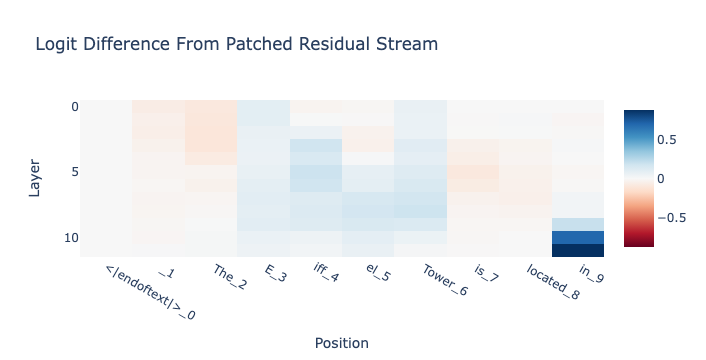

In [91]:
prompt_position_labels = [f"{tok}_{i}" for i, tok in enumerate(og_str_tokens)]
imshow(patched_residual_stream_diff, x=prompt_position_labels, title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})

## Causal Trace on Layers

In [92]:
correct_answer

' Paris'

In [93]:
patched_attn_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
patched_mlp_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for position in range(padded_original_prompt_tokens.shape[1]):

        hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("attn_out", layer),
                hook_fn)],
            return_type="logits"
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(patched_attn_logits, correct_answer, incorrect_answer)
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("mlp_out", layer),
                hook_fn)],
            return_type="logits"
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(patched_mlp_logits, correct_answer, incorrect_answer)

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(patched_attn_logit_diff, corrupted_average_logit_diff,
                                                                                     original_average_logit_diff)
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(patched_mlp_logit_diff, corrupted_average_logit_diff,
                                                                                     original_average_logit_diff)

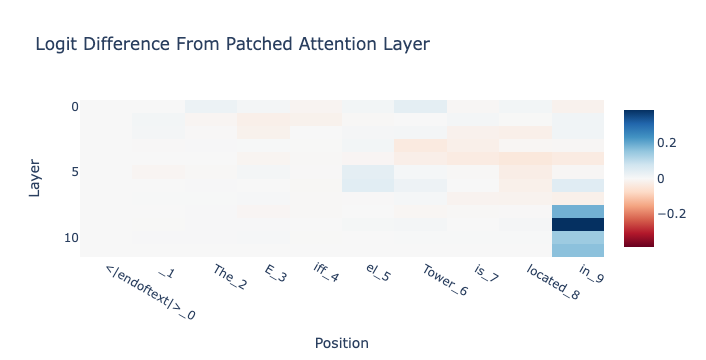

In [94]:
imshow(patched_attn_diff, x=prompt_position_labels, title="Logit Difference From Patched Attention Layer", labels={"x":"Position", "y":"Layer"})

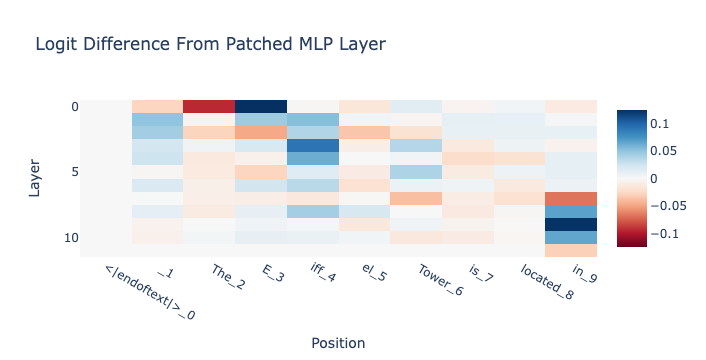

In [95]:
imshow(patched_mlp_diff, x=prompt_position_labels, title="Logit Difference From Patched MLP Layer", labels={"x":"Position", "y":"Layer"})

## Causal Trace on Heads

In [96]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][:, :, head_index, :]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cpu", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("z", layer, "attn"),
                hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, correct_answer, incorrect_answer)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(patched_logit_diff,  corrupted_average_logit_diff,
                                                                                     original_average_logit_diff)

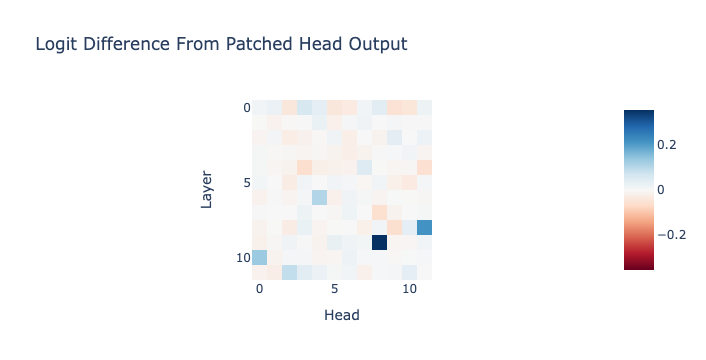

In [97]:
imshow(patched_head_z_diff, title="Logit Difference From Patched Head Output", labels={"x":"Head", "y":"Layer"})

In [98]:
from transformer_lens import SVDInterpreter

def plot_svd(layer, head, matrix):
    if matrix not in ["OV", "w_in", "w_out"]:
        raise ValueError
    def plot_matrix(matrix, tokens, k=10, filter="topk"):
        pysvelte.TopKTable(tokens=all_tokens, activations=matrix, obj_type="SVD direction", k=k, filter=filter).show()
    svd_interpreter = SVDInterpreter(model)
    all_tokens = [model.to_str_tokens(np.array([i])) for i in range(model.cfg.d_vocab)]
    all_tokens = [all_tokens[i][0] for i in range(model.cfg.d_vocab)]
    svd = svd_interpreter.get_singular_vectors(matrix, layer_index=layer, head_index=head)
    plot_matrix(svd, all_tokens)


plot_svd(layer=9, head=8, matrix="w_in")

NameError: name 'pysvelte' is not defined

## Causal Tracing like in ROMe

In [ ]:
from collections import defaultdict
import numpy as np
import os
from matplotlib import pyplot as plt
import re

def layername(model, num, kind=None):
    if hasattr(model, "transformer"):
        if kind == "embed":
            return "transformer.wte"
        return f'transformer.h.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "gpt_neox"):
        if kind == "embed":
            return "gpt_neox.embed_in"
        if kind == "attn":
            kind = "attention"
        return f'gpt_neox.layers.{num}{"" if kind is None else "." + kind}'
    assert False, "unknown transformer structure"

In [ ]:
def guess_subject(prompt):
    return re.search(r"(?!Wh(o|at|ere|en|ich|y) )([A-Z]\S*)(\s[A-Z][a-z']*)*", prompt)[
        0
    ].strip()

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = np.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [ ]:
x = model.to_tokens(["<|PAD|>"])

In [ ]:
x = torch.tensor([[0]])
model.to_string(x)

['!']

In [ ]:
model.tokenizer.pad_token_id

50256

In [ ]:
def make_inputs(model, prompts : List, device="cpu"):
    tokenized_prompts = [model.to_tokens(p) for p in prompts]
    maxlen = max([t.shape[-1] for t in tokenized_prompts])
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros((len(tokenized_prompts), maxlen))
    attention_masks = torch.zeros((len(tokenized_prompts), maxlen))
    for i, tok_prompt in enumerate(tokenized_prompts):
        n_pads = maxlen - tok_prompt.shape[-1]

        padded_tokenized_inputs[i, :n_pads] = pad_token
        padded_tokenized_inputs[i, n_pads:] = tok_prompt
        attention_masks[i, n_pads:] = 1
    return dict(
        input_ids=padded_tokenized_inputs.to(device),
        attention_masks=attention_masks.to(device)
    )


In [ ]:

def predict_from_input(model, input_tokens : torch.tensor):
    logits, cache = model.run_with_cache(prompt_tokens)
    probs = torch.softmax(logits[:, -1], dim=-1)
    p, preds = torch.max(probs, dim=-1)
    return dict(
        predictions=preds,
        probs=p,
        cache=cache
    )


def calculate_hidden_flow(
    model, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(model, [prompt] * (samples + 1))
    input_tokens = inp["input_ids"]

    with torch.no_grad():
        res = predict_from_input(model, inp)
    answer_tokens = res["predictions"]
    base_score = res["probs"]
    cache = res["cache"]

    answer = [model.to_single_str_token(s.item()) for s in toks]


    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [ ]:
def plot_hidden_flow(
    mt ,            #hooked_model
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(model, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            model, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

In [ ]:
def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [ ]:
noise_level = model.W_E.std(dim=-1).mean(dim=-1).item()
noise_level

0.14292709529399872

In [ ]:
plot_all_flow(model, "The Eiffel Tower is located in", noise=noise_level)

NameError: ignored

In [ ]:
toks = torch.tensor([ 262,  262, 3576,  262])



## Correcting the model using LORA
- We have identified Layer 9, head 8
- MLP layer 9
- MLP layer 8